In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from train_model import SimpleNN
from mfbox import gokunet_split


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


/home/yang/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# load input data
x_test = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/test_input.txt")
# normalize input data
bounds = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/input_limits.txt")
# x_test = (x_test - bounds[:,0]) / (bounds[:,1] - bounds[:,0])

y_test = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/test_output.txt")
y_test = 10**y_test


In [4]:
# load model
emu = gokunet_split(path_LA="models/pre_N_L1A_z0/best_model.pth",path_LB="models/pre_N_L2B_z0/best_model.pth",path_HA="models/pre_N_LHA_z0/best_model.pth", path_HB="models/pre_N_LHB_z0/best_model.pth", bounds_path="data/pre_N_xL-H_stitch_z0/input_limits.txt")

In [5]:
k, y_h_pred = emu.predict(x_test)
k_1, y_l1_pred = emu.predict_LA(x_test)
k_2, y_l2_pred = emu.predict_LB(x_test)

In [6]:
k_1.shape

(32,)

In [7]:
k.shape

(64,)

In [8]:
y_l1_pred.shape

(12, 32)

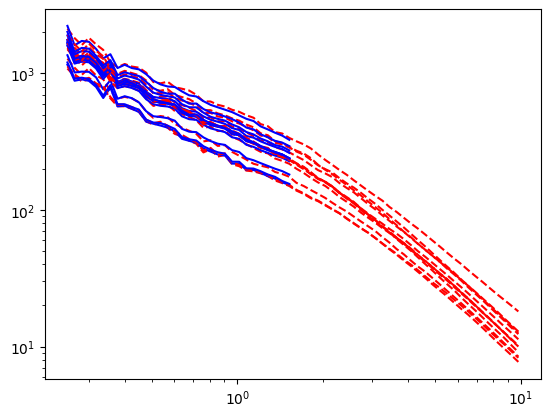

In [9]:
# Plot results
# plt.scatter(x, y, label="True Data")
# load k values

# plot in log-log scale
plt.figure()

# loop over all the test data
for i in range(y_h_pred.shape[0]):
    plt.loglog(k, y_test[i], color="red", linestyle="--", label="True Data") 
    # plt.loglog(k, y_h_pred[i], color="red", label="NN Prediction")
    plt.loglog(k_1, y_l1_pred[i], color="blue", label="NN L1 Prediction")
# plt.legend()
plt.show()

In [10]:
k.max()

np.float64(9.825361078106937)

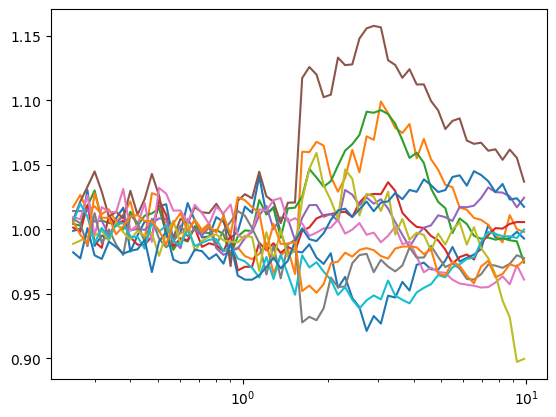

In [11]:
# plot ratio
plt.figure()

for i in range(y_h_pred.shape[0]):
    plt.semilogx(k, y_h_pred[i] / y_test[i])
# limit the y-axis
# plt.ylim(0.8, 1.2)
plt.show()

In [12]:
# calculate relative mean absolute error
rel_err = np.mean(np.abs(y_h_pred - y_test) / y_test)
print("Relative Mean Absolute Error:", rel_err)

Relative Mean Absolute Error: 0.023496799162666615


In [21]:
# if use the B region from xL model
from mfbox import gokunet
# load model
emu = gokunet(path_L1="models/pre_N_L1_z0/best_model.pth",path_L2="models/pre_N_L2_z0/best_model.pth",path_LH="models/pre_N_xLH_stitch_z0/best_model.pth",bounds_path="data/pre_N_xL-H_stitch_z0/input_limits.txt", stitch='XL')
k, y_h_stitch_pred = emu.predict(x_test)

KeyError: 'activation'

In [20]:
y_combined = np.concatenate(y_h_pred[:len(y_h_pred)//2] + y_h_stitch_pred[len(y_h_pred)//2:])
# relative mean absolute error
rel_err = np.mean(np.abs(y_combined - y_test) / y_test)
print("Relative Mean Absolute Error:", rel_err)

NameError: name 'y_h_stitch_pred' is not defined

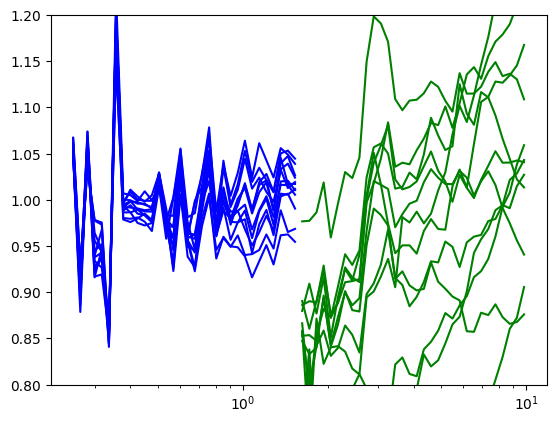

In [13]:
# plot ratio
plt.figure()

for i in range(y_h_pred.shape[0]):
    # plt.semilogx(k, y_h_pred[i] / y_test[i])
    plt.semilogx(k_1, y_l1_pred[i] / y_test[i][:32], color="blue")
    plt.semilogx(k_2, y_l2_pred[i] / y_test[i][32:], color="green")
# limit the y-axis
plt.ylim(0.8, 1.2)
plt.show()

In [14]:
# calculate mean square error (log scale)
mse = np.mean((np.log10(y_h_pred) - np.log10(y_test))**2)
print("Mean Square Error:", mse)

Mean Square Error: 0.0002123379577300376


In [15]:
# load HF training data
x_th = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/train_input_fidelity_1.txt")
y_th = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/train_output_fidelity_1.txt")
y_th = 10**y_th

In [16]:
# compare the prediction with the training data
_, y_th_pred = emu.predict(x_th)

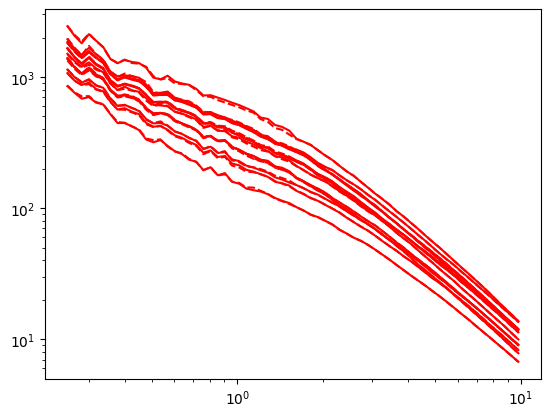

In [17]:


# plot in log-log scale
plt.figure()

# loop over all the test data 
for i in range(y_h_pred.shape[0]):
    plt.loglog(k, y_th[i], color="red", linestyle="--", label="True Data") 
    plt.loglog(k, y_th_pred[i], color="red", label="NN Prediction")
# plt.legend()
plt.show()


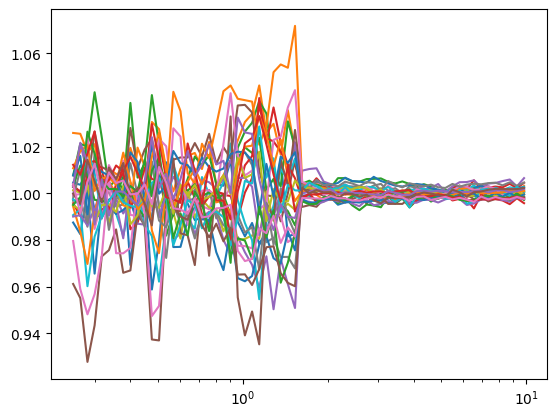

In [18]:
# plot ratio
plt.figure()

for i in range(y_th_pred.shape[0]):
    plt.semilogx(k, y_th_pred[i] / y_th[i])
# limit the y-axis
# plt.ylim(0.8, 1.2)
plt.show()

In [19]:
# calculate mean square error (log scale)
mse = np.mean((np.log10(y_th_pred) - np.log10(y_th))**2)
print("Mean Square Error:", mse)

Mean Square Error: 3.050504164090453e-05
